In [1]:
import numpy as np
import os
import cv2
import itertools
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.fftpack
%matplotlib inline

Using TensorFlow backend.


In [2]:
class RecognizeLp(object):
    def __init__(self):
        self.cntf = 0
        self.folder_nn = '/home/eugen/PycharmProjects/Rslp/FullOcrLp/nn/'
        self.nn_detect_lp = 'model-detect-lp'
        self.nn_ocr_lp = 'model-ocr-lp'
        self.dlp = self.__get_model_detect_lp()
        self.ocrlp = self.__get_model_ocr_lp()
        self.pdl = 0.6
        self.letters = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
              'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y', ' ']

    def __plot_images(self, images, grey):
        fig = plt.figure(figsize=(15, 18))
        for i in range(min(16, len(images))):
            fig.add_subplot(4, 4, i + 1)
            if grey:
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.show()

    def __detect_lp(self, img, file):
        img_crop = cv2.resize(img, (224, 224))
        img_crop = img_crop / 255
        img_crop = np.reshape(img_crop, (1, img_crop.shape[0], img_crop.shape[1], 1))
        pred = self.dlp.predict(img_crop)[0]
        mask = np.zeros(pred.shape)
        mask[pred >= self.pdl] = 255
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        mask = mask.astype(np.uint8)
        _, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
        if len(contours) == 0:
            return None
        cnt = contours[0]
        max_area = cv2.contourArea(cnt)
        for cont in contours:
            if cv2.contourArea(cont) > max_area:
                cnt = cont
                max_area = cv2.contourArea(cont)
        epsilon = 0.025 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        approx = np.reshape(approx, (approx.shape[0], 2))
        min_x, min_y = np.min(approx, axis=0)
        max_x, max_y = np.max(approx, axis=0)
        out = np.zeros_like(img)
        out[mask == 255] = img[mask == 255]
        img_gepotise = []
        md_arr = []
        for i in range(-10, 10):
            out = mask[min_y:max_y + 1, min_x:max_x + 1]
            out = self.__image_rotate(out, i)
            md = np.median(np.mean(out, axis=1))
            #print(md)
            #cv2.imwrite(str(i + 10) + '_' + str(round(md, 3)) + '_test.jpg', out)
            md_arr.append(md)
            out = img[min_y:max_y + 1, min_x:max_x + 1]
            out = self.__image_rotate(out, i)
            #out = cv2.resize(out, (128, 64))
            # out = np.expand_dims(out.T, -1)/255
            img_gepotise.append(out)
        mdmax = np.max(md_arr)
        maxs = np.where((md_arr >= np.uint32(mdmax)) & (md_arr <= mdmax))
        rimg = np.array(img_gepotise)[maxs]
        return rimg
    
    
    def __char_crop(self, img, mean_size=3, median_k_a=1.1, pix_shift_back=3, pix_shoft_forw=3,
                    char_size_min=5.5):
        mean_imgs = []
        imgs = []
        for i in range(0, img.shape[1]):
            mean_imgs.append(np.mean(img[:, i:i + mean_size]))
            i += mean_size
        med_all_img = np.median(mean_imgs) * median_k_a
        index = np.where(mean_imgs >= med_all_img)
        mean_imgs = np.array(mean_imgs)
        mean_imgs[index] = np.max(mean_imgs)
        index = np.where(mean_imgs >= np.max(mean_imgs))
        if len(index) > 0:
            index = index[0]
        if index[0] > (2 * mean_size):
            index = np.insert(index, 0, mean_size)
        for i in range(1, len(index)):
            if (index[i] - index[i - 1]) < char_size_min:
                continue
            li = index[i - 1] - pix_shift_back if index[i - 1] - pix_shift_back >= 0 else index[i - 1]
            ri = index[i] + pix_shoft_forw if index[i] + pix_shoft_forw <= img.shape[1] else img.shape[1]
            imgs.append(np.copy(img[0:img.shape[0], li:ri]))
        return imgs

    def __lp_crop(self, img, mean_size=2, max_crop=5):
        mean_imgs = []
        for i in range(0, img.shape[0]):
            mean_imgs.append(np.mean(img[i:i + mean_size, :]))
            i += mean_size
        med_all_img = np.mean(mean_imgs) * 0.8
        index = np.where(mean_imgs < med_all_img)
        hh = img.shape[0] * 0.5
        index = np.squeeze(index, -1)
        sl = index[index >= hh]
        if len(sl) > 0:
            l_top = np.min(sl)
            l_top = l_top if img.shape[0] - l_top <= max_crop else img.shape[0] - max_crop
            img[l_top: img.shape[0], :] = 255
        sl = index[index <= hh]
        if len(sl) > 0:
            l_bot = np.max(sl)
            l_bot = l_bot if l_bot <= max_crop else max_crop
            img[0:l_bot, :] = 255
        return img

    def __img_split(self, images, img_max_lenght=20):
        img_wb = []
        for i in range(0, len(images)):
            if images[i].shape[1] > img_max_lenght:
                img_wb.append(i)
        off_corr = 0
        for i in img_wb:
            imgs_split = self.__char_crop(images[i + off_corr], pix_shift_back=3, pix_shoft_forw=3)
            if len(imgs_split) > 0:
                images[i + off_corr] = imgs_split[0]
                inx = i + 1 + off_corr
                for y in range(1, len(imgs_split)):
                    images.insert(inx, imgs_split[y])
                    inx += 1
            off_corr += len(imgs_split) - 1
        return images

    #         cv2.imshow("Contour", cv2.resize(img, (img.shape[1] * 3, img.shape[0] * 3)))
    #         cv2.waitKey(2000)
    def __img_crop(self, img, mean_size=2, level_blank=2, invert=False):
        mean_imgs = []
        for i in range(0, img.shape[0]):
            mean_imgs.append(np.mean(img[i:i + mean_size, :]))
            i += mean_size
        index = np.where(mean_imgs >= np.int32(level_blank)) if invert else np.where(mean_imgs <= np.int32(level_blank))
        hh = img.shape[0] * 0.5
        index = np.squeeze(index, -1)
        sl = index[index >= hh]
        l_top = np.min(sl) - 1 if len(sl) > 0 else img.shape[0] - 1
        sl = index[index <= hh]
        l_bot = np.max(sl) + 1 if len(sl) > 0 else 1
        w = img.shape[1]
        h = l_top - l_bot
        imc = np.zeros((h, w))
        imc[:, :] = img[l_bot:l_top, :]
        return np.uint8(imc)

    def __img_crop_next(self, img, level_blank=5, axis=0):
        try:
            mean_imgs = np.mean(img, axis=axis)
            index = np.where(mean_imgs <= level_blank)
            if axis == 0:
                hw = int(np.mean(np.where(mean_imgs[20:44] == np.max(mean_imgs[20:44])))) + 20
            else:
                hw = img.shape[0] * 0.5
            shape_img = img.shape[1] if axis > 0 else img.shape[0]
            index = np.squeeze(index, -1)
            sl = index[index > hw]
            l_top = np.min(sl) - 1 if len(sl) > 0 else shape_img
            l_top = l_top if l_top >= 0 else shape_img
            sl = index[index < hw]
            l_bot = np.max(sl) + 1 if len(sl) > 0 else 0
            l_bot = l_bot if l_bot >= 0 else 0
            w = img.shape[1] if axis > 0 else l_top - l_bot
            h = img.shape[0] if axis == 0 else l_top - l_bot
            if h < 0:
                h = img.shape[0]
            if w < 0:
                w = img.shape[1]
            imc = np.zeros((h, w))
            imc[:, :] = img[l_bot:l_top, :] if axis > 0 else img[:, l_bot:l_top]
            return imc
        except:
            return None

    def __image_normalisation(self, image):
        try:
            koeff = 60 / image.shape[0]
            (h, w) = (int(image.shape[0]*koeff), int(image.shape[1]*koeff))
            image = 255-cv2.resize(image, (h, w))
            imr = np.zeros((64, 64))
            yo = int(0.5*64 - image.shape[0]*0.5)
            xo = int(0.5*64 - image.shape[1]*0.5)
            imr[yo:image.shape[0] + yo, xo:image.shape[1] + xo] = image[0:image.shape[0], 0:image.shape[1]]
            return imr
        except:
            return None

    def __image_conversion(self, image, lp_number):
        print(lp_number)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.adaptiveThreshold(image, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 3)
        kernel = np.ones((1, 1), np.uint8)
        image = cv2.erode(image, kernel, iterations=1)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 1))
        ret, image = cv2.threshold(image, 180, 255, 0)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        self.__plot_images([image], True)
        image = self.__lp_crop(image)
        images = self.__char_crop(image)
        
        images = self.__img_split(images)
        
        for i in range(0, len(images)):
            img = self.__img_crop(images[i])
            if img is None:
                continue
            img = self.__img_crop(img, level_blank=251, invert=True)
            if img is None:
                continue
            img = self.__image_normalisation(img)
            if img is None:
                continue
            img = self.__img_crop_next(img)
            if img is None:
                continue
            img = self.__img_crop_next(img, axis=1)
            if img is None:
                continue
            koeff1 = 30 / img.shape[0]
            koeff2 = 45 / img.shape[1]
            (h, w) = (int(img.shape[0]*koeff1), int(img.shape[1]*koeff2))
            img = cv2.resize(img, (h, w))
            imr = np.zeros((64, 64))
            yo = int(0.5 * 64 - img.shape[0] * 0.5)
            xo = int(0.5 * 64 - img.shape[1] * 0.5)
            imr[yo:img.shape[0] + yo, xo:img.shape[1] + xo] = img[0:img.shape[0], 0:img.shape[1]]
            images[i] = imr
        self.__plot_images(images, True)
        return images

    def __image_rotate(self, img, angle):
        image_center = tuple(np.array(img.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=255)
        return result

    def __image_ocr(self, images):
        images = np.array(images)/255
        images = np.reshape(images, images.shape + (1, ))
        predict = self.ocrlp.predict_classes(images)
        return predict

    def recognize(self, image, file):
        return self.__detect_lp(image, file)
        if img is not None:
            for im in img:
                images = self.__image_conversion(im, file)
                lps = self.__image_ocr(images)
                number = ''
                for ch in lps:
                    number += self.letters[ch]
                print(number)
            # self.__ocr_license_plate(img)
        else:
            print('bad!!!')
            
    def __get_model_detect_lp(self):
        json_file = open(self.folder_nn + self.nn_detect_lp + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(self.folder_nn + self.nn_detect_lp + '.h5')
        loaded_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        return loaded_model


    def __get_model_ocr_lp(self):
        json_file = open(self.folder_nn + self.nn_ocr_lp + '.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(self.folder_nn + self.nn_ocr_lp + '.h5')
        loaded_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy')
        return loaded_model


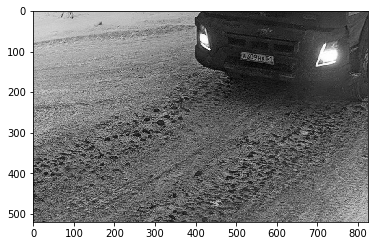

In [ ]:
IMG_PATH = '/mnt/misk/misk/lplate/temp/chars/2f293653-511b-474a-af91-6532e9783a22'
IMG_FOR_OCR = '/mnt/misk/misk/lplate/chars'
rc = RecognizeLp()
#for file in os.listdir(IMG_PATH):
file = '942698c5-9478-4e15-9f5e-69614cf6bbff.jpg'#'08-12-2018_22-03-35_2.jpg'#'FirstFN_cam2 (536).jpg'
fp = os.path.join(IMG_PATH, file)
img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
#_, img = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY)
plt.imshow(img, cmap='gray')
plt.show()
fn = os.path.splitext(file)[0].split('_')
imgs = rc.recognize(img, fn)

In [5]:
def plot_images(images, grey):
    fig = plt.figure(figsize=(15, 18))
    for i in range(min(16, len(images))):
        fig.add_subplot(4, 4, i + 1)
        if grey:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
    plt.show()

In [ ]:
plot_images(imgs, True)

In [20]:
img = cv2.GaussianBlur(imgs[0], (9, 9), 10)
#img = cv2.bilateralFilter(imgs[0],1,75,75)
img = cv2.subtract(img, imgs[0])
#imgb = cv2.GaussianBlur(imgs[0], (1, 1), 3)
#imgb = cv2.subtract(imgb, img)
#kernel = np.ones((1, 5), np.uint8)
#img = cv2.dilate(img, kernel, iterations=1)
#img = cv2.GaussianBlur(img, (1, 1), 1)
#img = cv2.subtract(imgs[0], img)
#cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
#kernel = np.ones((1, 1), np.uint8)
#img = cv2.dilate(img, kernel, iterations=2)
#img = cv2.GaussianBlur(img, (1, 1), 1)
ret, img = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)      # 1 chan, grayscale!
plot_images([img], True)

TypeError: 'NoneType' object is not subscriptable

In [7]:
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    _, contours, _ = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

In [8]:
#### imclearborder definition

def imclearborder(imgBW, radius):

    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    _, contours, _ = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy


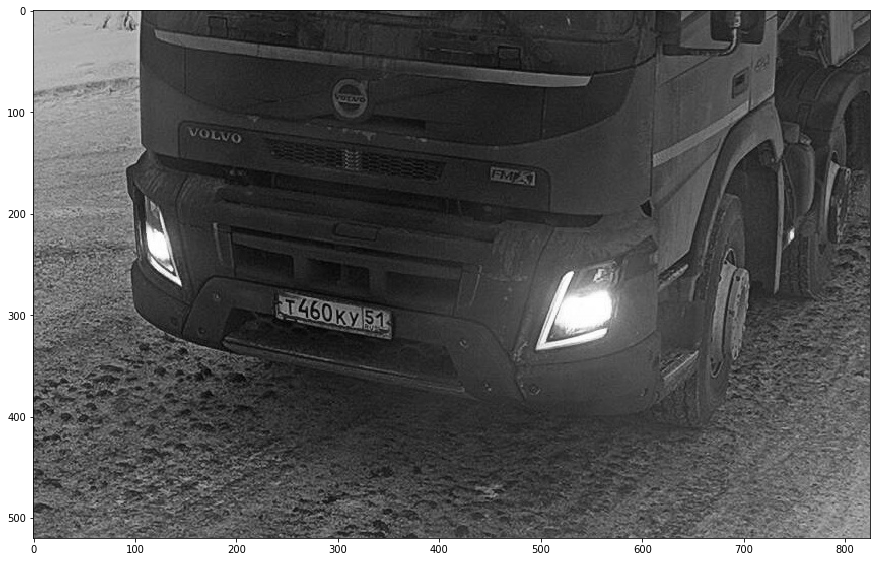

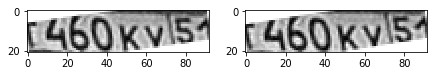

In [73]:
# Convert image to 0 to 1, then do log(1 + I)
imis = img.copy()
(rows, cols) = img.shape
imgLog = np.log1p(np.array(img, dtype="float") / 255)

# Create Gaussian mask of sigma = 10
M = 2*rows + 1
N = 2*cols + 1
sigma = 10
(X,Y) = np.meshgrid(np.linspace(0,N-1,N), np.linspace(0,M-1,M))
centerX = np.ceil(N/2)
centerY = np.ceil(M/2)
gaussianNumerator = (X - centerX)**2 + (Y - centerY)**2

# Low pass and high pass filters
Hlow = np.exp(-gaussianNumerator / (2*sigma*sigma))
Hhigh = 1 - Hlow

# Move origin of filters so that it's at the top left corner to
# match with the input image
HlowShift = scipy.fftpack.ifftshift(Hlow.copy())
HhighShift = scipy.fftpack.ifftshift(Hhigh.copy())

# Filter the image and crop
If = scipy.fftpack.fft2(imgLog.copy(), (M,N))
Ioutlow = scipy.real(scipy.fftpack.ifft2(If.copy() * HlowShift, (M,N)))
Iouthigh = scipy.real(scipy.fftpack.ifft2(If.copy() * HhighShift, (M,N)))

# Set scaling factors and add
gamma1 = 0.3
gamma2 = 1.5
Iout = gamma1*Ioutlow[0:rows,0:cols] + gamma2*Iouthigh[0:rows,0:cols]

# Anti-log then rescale to [0,1]
Ihmf = np.expm1(Iout)
Ihmf = (Ihmf - np.min(Ihmf)) / (np.max(Ihmf) - np.min(Ihmf))
Ihmf2 = np.array(255*Ihmf, dtype="uint8")

#img = cv2.GaussianBlur(Ihmf2, (1, 1), 1)
#img = cv2.subtract(imgs[0], img)
#ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV)

# Threshold the image - Anything below intensity 65 gets set to white
Ithresh = Ihmf2 < 80
#ret, Ithresh = cv2.threshold(np.uint8(Ihmf2), 250, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
Ithresh =255-Ithresh.astype("uint8")
imgrc = cv2.add(0.8*imis, 0.5*Ithresh)

imgs = rc.recognize(imgrc, fn)
plt.figure(figsize=(15, 18))
plt.imshow(imgrc, cmap='gray')
plt.show()
plot_images(imgs, True)
#Iopen = imclearborder(Ithresh, 3)
#Iopen = bwareaopen(Iopen, 10)
#plot_images([Iopen], True)

In [360]:
def char_crop(img, mean_size=3, median_k_a=1.1, mdedian_k_b=1.2, pix_shift_back=2, pix_shoft_forw=4, char_size_min=5.5):
    mean_imgs = []
    imgs = []
    for i in range(0, img.shape[1]):
        mean_imgs.append(np.mean(img[:, i:i + mean_size]))
        i += mean_size
    med_all_img = np.median(mean_imgs)*median_k_a
    index = np.where(mean_imgs >= med_all_img)
    mean_imgs = np.array(mean_imgs)
    mean_imgs[index] = np.max(mean_imgs)
    index = np.where(mean_imgs >= np.max(mean_imgs))
    plt.plot([0, img.shape[1]], [med_all_img, med_all_img])
    plt.plot(mean_imgs)
    if len(index) > 0:
        index = index[0]
    if index[0] > (2*mean_size):
        index = np.insert(index, 0, mean_size)
    for i in range(1, len(index)):
        if (index[i] - index[i-1]) < char_size_min:
            continue
        li = index[i-1]-pix_shift_back if index[i-1]-pix_shift_back >= 0 else index[i-1]
        ri = index[i]+pix_shoft_forw if index[i]+pix_shoft_forw <= img.shape[1] else img.shape[1]
        imgs.append(np.copy(img[0:img.shape[0], li:ri]))
    mean_imgs = np.mean(img, axis=0)
    plt.plot(mean_imgs)
    return imgs

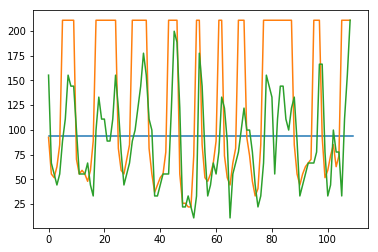

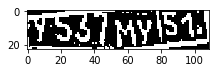

In [297]:

char_crop(image)
plot_images([image], True)

In [307]:
def get_split_mask(image, char_size_min=10, char_size=10):
    #img = cv2.GaussianBlur(image, (23, 23), 0)
    #img = cv2.subtract(img, image)
    #cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    #ret, img = cv2.threshold(img, 5, 255, 0)
    img = cv2.GaussianBlur(image, (9, 9), 10)
    img = cv2.subtract(img, image)
    #cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    #img = cv2.bilateralFilter(image,1,75,75)
    #img = cv2.subtract(img, image)
    #imgb = cv2.GaussianBlur(image, (5, 5), 1)
    #imgb = cv2.subtract(imgb, img)
    #img = cv2.subtract(imgb, image)
   # kernel = np.ones((2, 2), np.uint8)
    #img = cv2.dilate(img, kernel, iterations=2)
    #img = cv2.subtract(image, img)
    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    #img = cv2.GaussianBlur(img, (1, 1), 10)
    ret, img = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    mean_imgs = np.mean(np.mean(img, axis=1))*1.5
    #print(mean_imgs)
    #img = img_crop_next(img, level_blank=mean_imgs, axis=1, lt=False)
    img = cv2.resize(img, (128, 64))
    mean_imgs = np.mean(img, axis=0)
    mean_imgs = np.mean(img, axis=0)
    fig = plt.figure(figsize=(15,18))
    imgplot = plt.imshow(img, cmap='gray')
    plt.plot(mean_imgs)
    mask_index_split = []
    i = 0
    fi = int(char_size/2)
    index = np.where(mean_imgs[i:i+fi] == np.min(mean_imgs[i:i+fi]))
    i = np.max(index)
    mask_index_split.append(i)
    while (i+char_size) < len(mean_imgs):
        index = np.where(mean_imgs[i:i+char_size] == np.min(mean_imgs[i:i+char_size]))
        n = np.min(index)+i
        print(i, n, n-i)
        if len(mask_index_split) and (n - mask_index_split[len(mask_index_split)-1]) <= char_size_min:
            i += char_size
        else:
            mask_index_split.append(n)
            i = n + int(char_size/2)
    images = []
    image = cv2.resize(image, (image.shape[1], img.shape[0]))
    for i in range(1, len(mask_index_split)):
        images.append(img[:, mask_index_split[i-1]: mask_index_split[i]])
    return images


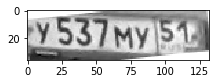

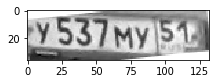

0 6 6
10 19 9
24 32 8
37 45 8
50 57 7
62 66 4
72 75 3
80 87 7
92 93 1
102 103 1
108 114 6


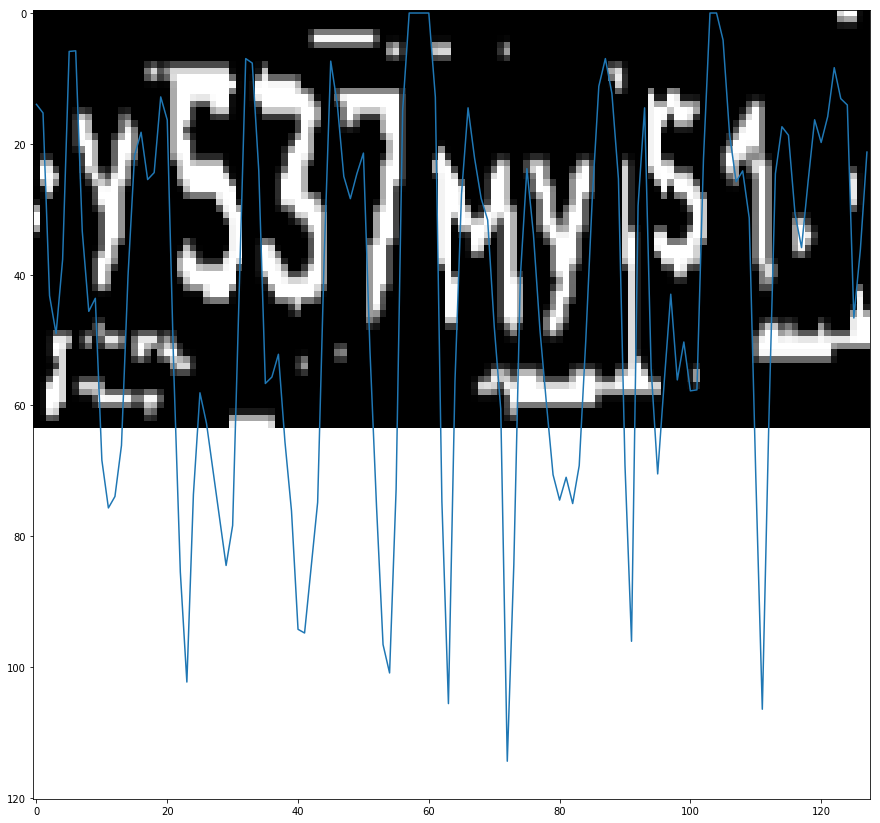

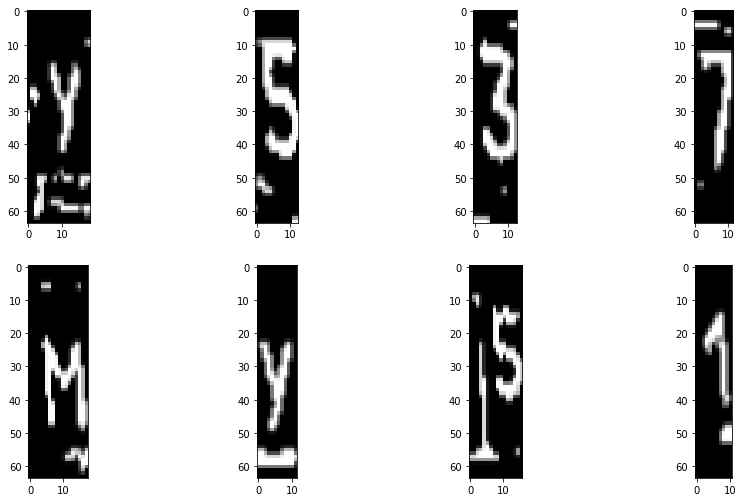

In [308]:
plot_images(imgs, True)
plot_images(imgs, True)
images = get_split_mask(imgs[0])
kernel = np.ones((3, 2), np.uint8)
#for i in range(0, len(images)):     
#    images[i] = cv2.erode(images[i], kernel, iterations=2)
plot_images(images, True)

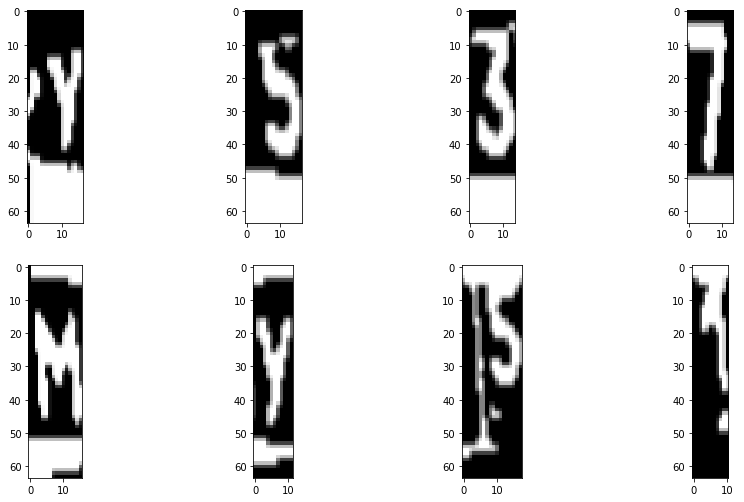

In [254]:
plot_images(images, True)

In [48]:
def img_crop_next(img, level_blank=5, axis=0, lt=True):
        mean_imgs = np.mean(img, axis=axis)
        plt.plot(mean_imgs)
        plt.show()
        index = np.where(mean_imgs <= level_blank) if lt else np.where(mean_imgs >= level_blank)
        if axis == 0:
            hw = img.shape[1] * 0.5
        else:
            hw = img.shape[0] * 0.5
        shape_img = img.shape[1] if axis == 0 else img.shape[0]
        index = np.squeeze(index, -1)
        sl = index[index > hw]
        l_top = np.min(sl) - 1 if len(sl) > 0 else shape_img
        l_top = l_top if l_top >= 0 else shape_img
        sl = index[index < hw]
        l_bot = np.max(sl) + 1 if len(sl) > 0 else 0
        l_bot = l_bot if l_bot >= 0 else 0
        w = img.shape[1] if axis > 0 else l_top - l_bot
        h = img.shape[0] if axis == 0 else l_top - l_bot
        print(w, h)
        if h < 0:
            h = img.shape[0]
        if w < 0:
            w = img.shape[1]
        imc = np.zeros((h, w))
        imc[:, :] = img[l_bot:l_top, :] if axis > 0 else img[:, l_bot:l_top]
        
        return imc

In [49]:
def img_crop_next_2(img, axis=0, level=5, findk=0.15):
    mean_imgs = np.mean(img, axis=axis)
    plt.plot(mean_imgs)
    plt.plot([0, img.shape[1]], [np.mean(mean_imgs), np.mean(mean_imgs)])
    plt.show()   
    hw = (img.shape[0] if axis else img.shape[1])
    fa = int(hw*0.5 - hw*0.5*findk)
    fb = int(hw*0.5 + hw*0.5*findk)
    fa = 0 if fa < 0 else fa
    fb = len(mean_imgs) if fb > len(mean_imgs) else fb
    mean_a = mean_imgs[:fa]
    mean_b = mean_imgs[fb:]
    mni = np.median(mean_imgs)
    wsa, ima = max_window(mean_a, mni, 0)
    wsb, imb = max_window(mean_b, mni, fb)
    fa = ima
    fb = imb
    if wsa == 0:
        fa = imb
    if wsb == 0:
        fb = ima
    if wsa*2.5 < wsb:
        fa = imb
    if wsb*2.5 < wsa:
        fb = fa
    fa = 0 if fa < 0 else fa
    fb = len(mean_imgs) if fb > len(mean_imgs) else fb
    mean_a = mean_imgs[:fa]
    mean_b = mean_imgs[fb:]
    index = np.where((mean_a <= np.min(mean_a)) & (mean_a <= level))
    index = 0 if len(index[0]) == 0 else np.max(index)
    print(index)
    l_bot = index if index > 0 else 0
    index = np.where((mean_b <= np.min(mean_b)) & (mean_b <= level))
    index = hw if len(index[0]) == 0 else np.min(index) + fb
    print(index)
    l_top = index if index <= hw else hw
    w = img.shape[1] if axis > 0 else l_top - l_bot
    h = img.shape[0] if axis == 0 else l_top - l_bot
    imc = np.zeros((h, w))
    imc[:, :] = img[l_bot:l_top, :] if axis > 0 else img[:, l_bot:l_top]
    plt.imshow(imc, cmap='gray')
    plt.show()
    return imc

In [50]:
def max_window(data, level, offset=0):
    index = np.where(data >= level)
    if len(index) == 0 or len(index[0]) == 0:
        return 0, 0
    __index = index[0]
    windows_size = __index[len(__index)-1] - __index[0]
    windows_max_value = int(np.mean(index)) + offset
    print(windows_size, windows_max_value)
    return windows_size, windows_max_value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


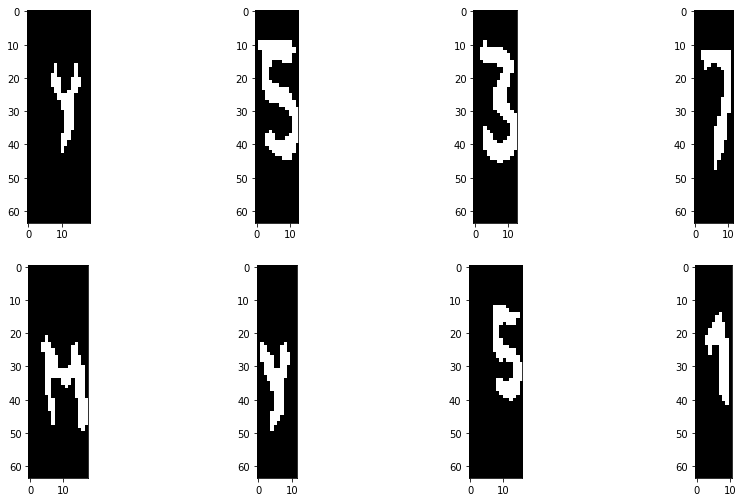

In [309]:

outs =[]
kernel = np.ones((3,1),np.uint8)
for i in range(0, len(images)):
     #img_crop_next_2(images[i], axis=1)
    #img = cv2.erode(images[i].copy(), kernel, iterations = 1)
    ret, img = cv2.threshold(images[i], 100, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    (_, contours, _) = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    if len(contours) == 0:
        continue
    cnt = contours[0]
    max_area = cv2.contourArea(cnt)
    for cont in contours:
        if cv2.contourArea(cont) > max_area:
            cnt = cont
            max_area = cv2.contourArea(cont)
    #epsilon = 0.015 * cv2.arcLength(cnt, True)
    #approxx = cv2.approxPolyDP(cnt, epsilon, True)
    #approx = np.reshape(approxx, (approxx.shape[0], 2))
    #min_x, min_y = np.min(approx, axis=0)
    #max_x, max_y = np.max(approx, axis=0)
    out = np.zeros_like(img)
    cv2.fillPoly(out, pts =[cnt], color=(255))
    #out[min_y:max_y, min_x:max_x]=255
    out[out==255] = images[i][out==255]    
    number = cv2.cvtColor(np.float32(out), cv2.COLOR_GRAY2BGR)
    #cv2.drawContours(number, approxx, -1, (0, 255, 0), 1)
    outs.append(number)
    #images[i] = out
    #images[i] = img_crop_next_2(images[i], axis=1)
    #images[i] = img_crop_next_2(images[i], axis=0)
plot_images(outs, False)

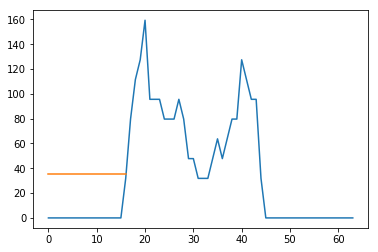

26 13
27 49
12
49


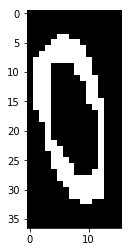

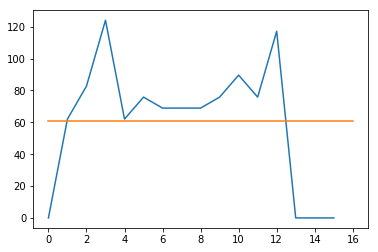

3 3
3 10
0
13


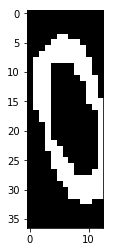

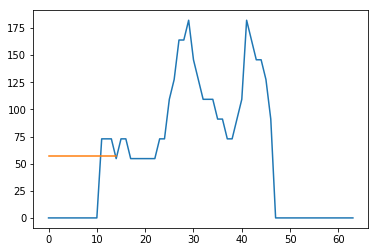

15 18
10 41
10
47


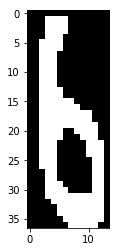

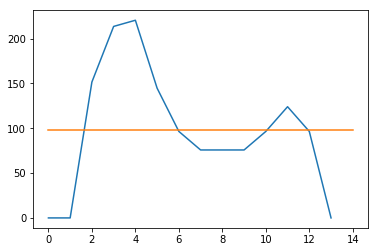

2 3
2 11
1
13


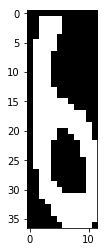

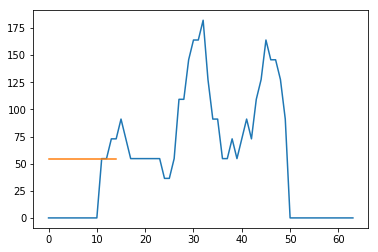

15 17
13 42
10
50


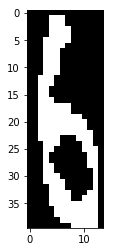

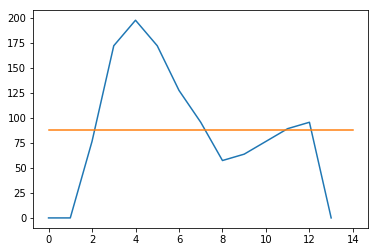

1 3
1 11
1
13


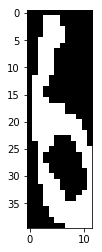

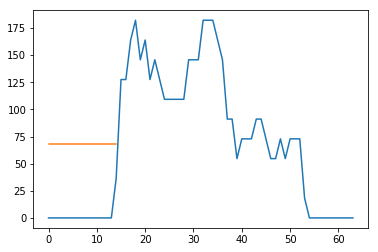

11 20
16 43
13
54


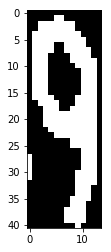

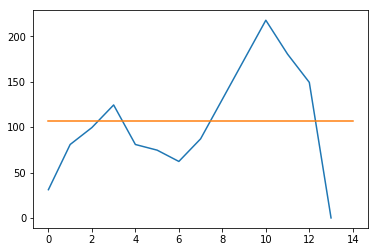

1 2
4 10
0
13


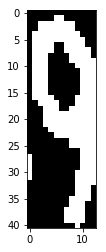

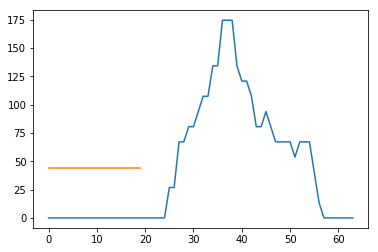

1 25
20 46
24
57


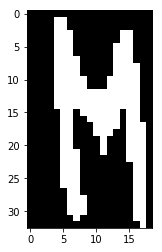

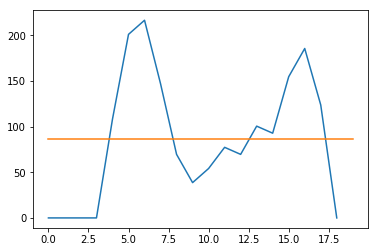

3 5
6 14
3
18


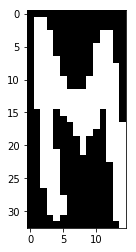

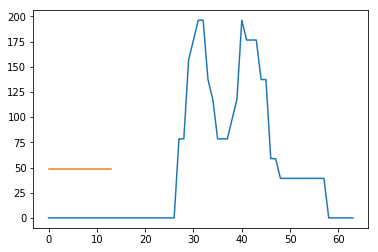

26 13
27 49
12
58


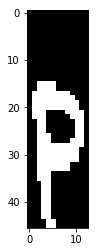

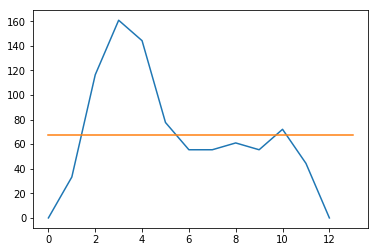

2 3
3 8
0
12


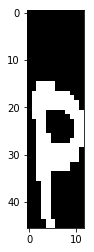

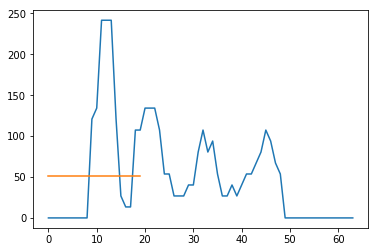

17 17
12 42
8
49


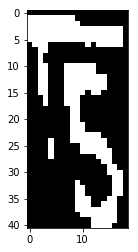

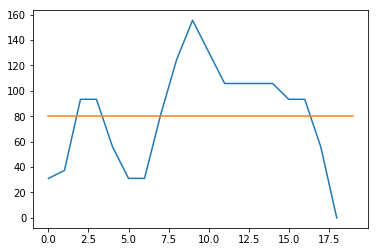

1 2
6 13
0
18


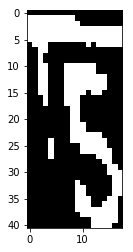

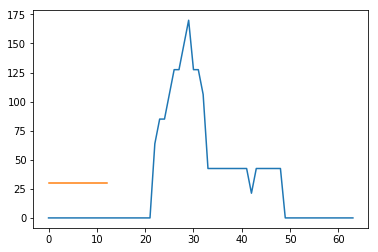

26 13
27 49
12
49


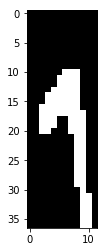

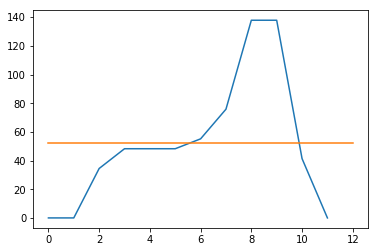

1 3
3 7
1
11


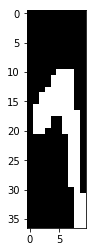

IndexError: list index out of range

In [210]:

crimg = []
kernel = np.ones((0,2),np.uint8)
for i in range(0, len(images[i])):
    ret, img = cv2.threshold(images[i], 200, 255, 0)
    img = img_crop_next_2(img, axis=1)
    img = img_crop_next_2(img, axis=0)
    crimg.append(img)
plot_images(crimg, False)

In [381]:
 def image_normalisation(image):
        try:
            image = cv2.resize(image, (24, 38))
            imr = np.zeros((64, 64))
            yo = int(0.5*64 - image.shape[0]*0.5)
            xo = int(0.5*64 - image.shape[1]*0.5)
            imr[yo:image.shape[0] + yo, xo:image.shape[1] + xo] = image[0:image.shape[0], 0:image.shape[1]]
            return imr
        except:
            return None

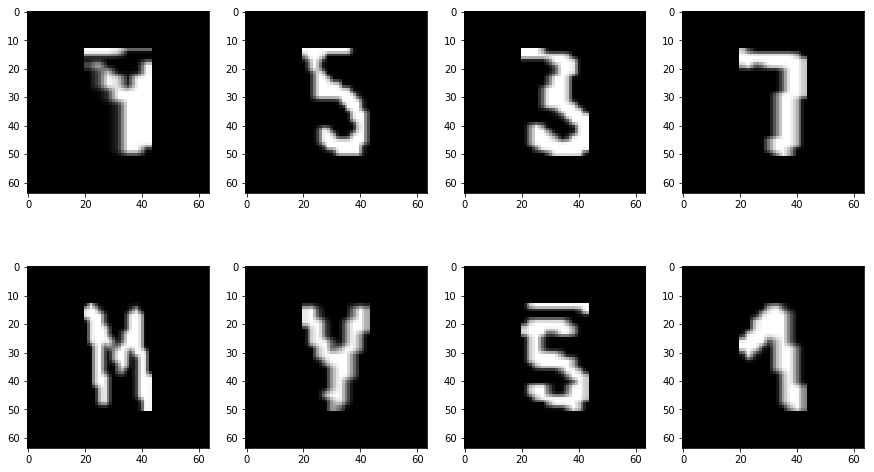

In [429]:
images = [x for x in images if x is not None]
for i in range(0, len(images)):     
    images[i] = image_normalisation(images[i])
plot_images(images, True)